In [42]:
import gymnax
import gymnasium as gym
import jax
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from RLinJAX import *
import pickle

# Mountain Car Environment 

In [43]:
env = gym.make("MountainCar-v0")

The mountain car environment is a classic reinforcement learning environment where the agent is challenged in terms of control and decision-making. This environment is used to test various reinforcement learning algorithms.

## Problem Description

In this environment the agent controls a car that is located at the bottom of a valley, and the goal is to reach the top of the hill. However, the car doesn't have enough speed to reach the top, and has to use momentum to gain speed to reach the goal, where elements such as position, speed and gravity are effects that the agent has to take into account.

## Key Components

This environment has 3 discrete actions in the action space:

In [46]:
action_space = env.action_space
print(action_space)
print("Number of actions:", action_space.n)

Discrete(3)
Number of actions: 3


These actions can be:
- 0: accelerate to the left 
- 1: do not accelerate
- 2: accelerate to the right

The observation space is represented by a two-dimensional array consisting of:

- Position: The position of the car on the x-axis where the values are between -1.2 and 0.6.
- Velocity : The velocity of the car with values between -0.07 and 0.07

In [50]:
observation_space = env.observation_space
print(observation_space)
print("Observation space low values:", observation_space.low)
print("Observation space high values:", observation_space.high)

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Observation space low values: [-1.2  -0.07]
Observation space high values: [0.6  0.07]


## Transition Dynamics

Given a certain action, the car uses the following formulas to calculate its next position and speed:

- velocity(t+1) = velocity(t) + (action - 1) * force - cos(3 * position(t)) * gravity

- position(t+1) = position(t) + velocity(t+1)

Force assumes a value of 0.001 and gravity assumes a value of 0.0025.

## Reward 

The objective of this environment is to reach the top of the hill and every time this agent executes a timestep its reward is penalized with -1.

## Starting State and Episode End 

At the start of each episode, the car's position takes on a random value between -0.6 and -0.4 and a velocity always equal to 0.

This episode ends in two situations:

- The car reaches a position greater than or equal to 0.5 (goal position, at the top of the hill on the right).

- The agent fails to reach the goal before using the maximum number of steps. And the episode ends


# Q-Learning

In [47]:
# Get the observation space
observation_space = env.observation_space
print(observation_space)
# Print the min and max values for the observation space
print("Observation space low values:", observation_space.low)
print("Observation space high values:", observation_space.high)

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Observation space low values: [-1.2  -0.07]
Observation space high values: [0.6  0.07]


In [48]:
action_space = env.action_space
print("Number of actions:", action_space.n)

Number of actions: 3


In [49]:
print(action_space)
print(observation_space)

Discrete(3)
Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


In [6]:
num_position_bins = 20
num_velocity_bins = 15
position_bins = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num_position_bins)
velocity_bins = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num_velocity_bins)

#print(position_bins)
#print(velocity_bins)

In [7]:
# Q-table initialization
num_actions = env.action_space.n

In [8]:
def discretize_state(state):
    position, velocity = state
    position_bin = np.digitize(position, position_bins) - 1  
    velocity_bin = np.digitize(velocity, velocity_bins) - 1
    position_bin = np.clip(position_bin, 0, num_position_bins - 1)
    velocity_bin = np.clip(velocity_bin, 0, num_velocity_bins - 1)
    return position_bin, velocity_bin

In [9]:
def epsilon_greedy(state, epsilon, q_values_table, num_actions):
    if random.uniform(0, 1) < epsilon:
        return random.choice(range(num_actions))
    else:
        position_bin, velocity_bin = state
        return np.argmax(q_values_table[position_bin, velocity_bin])

In [10]:
def train_q_learning(env, num_position_bins, num_velocity_bins, num_episodes, num_steps, alpha, gamma, epsilon, epsilon_decay, min_epsilon):
    # Initialize Q-table
    num_actions = env.action_space.n
    q_values_table = np.zeros((num_position_bins, num_velocity_bins, num_actions))

    # Tracking metrics
    episode_rewards = []
    episode_lengths = []
    goal_reached = False
    best_q_table = None
    best_reward = -float("inf")  # Initialize to very low value

    for episode in range(num_episodes):
        # Initialize the state by resetting the environment
        state, _ = env.reset()
    
        # Discretize the state
        discretized_state = discretize_state(state, num_position_bins, num_velocity_bins, env)
    
        total_reward = 0
        for step in range(num_steps):
            # Select the action using the epsilon-greedy policy
            action = epsilon_greedy(discretized_state, epsilon, q_values_table, num_actions)
    
            # Perform the selected action and store the next state information
            next_state, reward, done, _, _ = env.step(action)
    
            # Discretize the next state
            discretized_next_state = discretize_state(next_state, num_position_bins, num_velocity_bins, env)
    
            # Find the action a' with the maximum Q-value in the next state
            next_action = np.argmax(q_values_table[discretized_next_state])
    
            # Update Q-value of the state-action pair using the Q-learning update rule
            q_values_table[discretized_state[0], discretized_state[1], action] += alpha * (
                reward + gamma * q_values_table[discretized_next_state[0], discretized_next_state[1], next_action]
                - q_values_table[discretized_state[0], discretized_state[1], action]
            )
    
            # Update current state to next state
            discretized_state = discretized_next_state
    
            # Accumulate total reward
            total_reward += reward

            # If the current state is the terminal state, break
            if done:
                goal_reached = True
                break
                
        
        if total_reward > best_reward:
            best_reward = total_reward
            best_q_table = q_values_table.copy()  

        episode_rewards.append(total_reward)
        episode_lengths.append(step + 1)  

        # Decay epsilon
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

    # Calculate averages
    average_reward_all_episodes = np.mean(episode_rewards)
    average_reward_last_100_episodes = (np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else average_reward_all_episodes)

    result = {
        "average_reward_all_episodes": average_reward_all_episodes,
        "average_reward_last_100_episodes": average_reward_last_100_episodes,
        "episode_lengths": episode_lengths,
        "episode_rewards": episode_rewards,
        "alpha": alpha,
        "gamma": gamma,
        "epsilon_decay": epsilon_decay,
        "min_epsilon": min_epsilon,
        "goal_reached": goal_reached,
        "q_values_table": q_values_table, 
        "best_q_table": best_q_table,  
    }

    return result


In [ ]:
num_episodes = 50000
num_steps = 200
epsilon = 1.0  

alpha_values = [0.01, 0.1, 0.15]  
gamma_values = [0.8, 0.9, 0.99]   
epsilon_decay_values = [0.999, 0.9995, 0.9999]  
min_epsilon_values = [0.05, 0.1] 

all_results = []

total_iterations = len(alpha_values) * len(gamma_values) * len(epsilon_decay_values) * len(min_epsilon_values)
current_iteration = 0

for alpha in alpha_values:
    for gamma in gamma_values:
        for epsilon_decay in epsilon_decay_values:
            for min_epsilon in min_epsilon_values:
                current_iteration += 1
                print(f"Progress: {current_iteration}/{total_iterations} ({(current_iteration / total_iterations) * 100:.2f}%)")
                
                result = train_q_learning(env, num_position_bins ,num_velocity_bins , num_episodes, num_steps, alpha, gamma, epsilon, epsilon_decay, min_epsilon)
                all_results.append(result)

with open("q_learning_results.pickle", "wb") as f:
    pickle.dump(all_results, f)


In [18]:
# Load the results from the pickle file
with open("q_learning_results.pickle", "rb") as f:
    all_results = pickle.load(f)

max_avg_reward = all_results[0]["average_reward_all_episodes"]
max_avg_reward_index = 0

max_avg_last_100 = all_results[0]["average_reward_last_100_episodes"]
max_avg_last_100_index = 0

for i in range(1, len(all_results)):
    result = all_results[i]
    
    if result["average_reward_all_episodes"] > max_avg_reward:
        max_avg_reward = result["average_reward_all_episodes"]
        max_avg_reward_index = i

    if result["average_reward_last_100_episodes"] > max_avg_last_100:
        max_avg_last_100 = result["average_reward_last_100_episodes"]
        max_avg_last_100_index = i

print(f"Maximum average reward (all episodes): {max_avg_reward} at index {max_avg_reward_index}")
print(f"Maximum average reward (last 100 episodes): {max_avg_last_100} at index {max_avg_last_100_index}")

print("\nParameters for max average reward (all episodes):")
params_all_episodes = {
    "alpha": all_results[max_avg_reward_index]["alpha"],
    "gamma": all_results[max_avg_reward_index]["gamma"],
    "epsilon_decay": all_results[max_avg_reward_index]["epsilon_decay"],
    "min_epsilon": all_results[max_avg_reward_index]["min_epsilon"],
    "goal_reached": all_results[max_avg_reward_index]["goal_reached"],
}
print(params_all_episodes)

print("\nParameters for max average reward (last 100 episodes):")
params_last_100 = {
    "alpha": all_results[max_avg_last_100_index]["alpha"],
    "gamma": all_results[max_avg_last_100_index]["gamma"],
    "epsilon_decay": all_results[max_avg_last_100_index]["epsilon_decay"],
    "min_epsilon": all_results[max_avg_last_100_index]["min_epsilon"],
    "goal_reached": all_results[max_avg_last_100_index]["goal_reached"],
}
print(params_last_100)

episode_rewards_best_average = all_results[max_avg_reward_index]["episode_rewards"]
episode_rewards_best_last_100 = all_results[max_avg_last_100_index]["episode_rewards"]

episode_lengths_best_average = all_results[max_avg_reward_index]["episode_lengths"]
episode_lengths_best_last_100 = all_results[max_avg_last_100_index]["episode_lengths"]

Maximum average reward (all episodes): -167.96168 at index 30
Maximum average reward (last 100 episodes): -140.08 at index 10

Parameters for max average reward (all episodes):
{'alpha': 0.1, 'gamma': 0.99, 'epsilon_decay': 0.999, 'min_epsilon': 0.05, 'goal_reached': True}

Parameters for max average reward (last 100 episodes):
{'alpha': 0.01, 'gamma': 0.9, 'epsilon_decay': 0.9999, 'min_epsilon': 0.05, 'goal_reached': True}


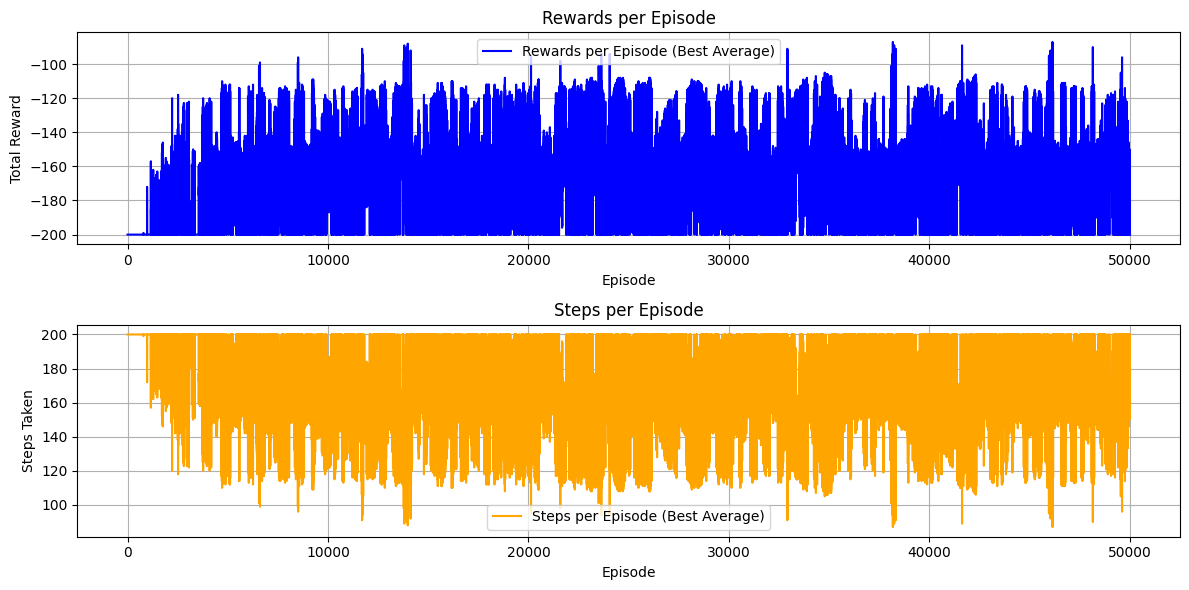

In [24]:
# Plot Rewards per Episode
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(episode_rewards_best_average, label="Rewards per Episode", color="blue")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Rewards per Episode")
plt.grid(True)
plt.legend()

# Plot Steps per Episode
plt.subplot(2, 1, 2)
plt.plot(episode_lengths_best_average, label="Steps per Episode", color="orange")
plt.xlabel("Episode")
plt.ylabel("Steps Taken")
plt.title("Steps per Episode")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Deep Q-Network (dqn)

In [19]:
rng = jax.random.PRNGKey(0)
rng, key_reset, key_policy, key_step = jax.random.split(rng, 4)
env, env_params = gymnax.make('MountainCar-v0')

In [20]:
CONFIGS = {"dqn":{"agent": "DuelingQNetwork",
                  "agent_kwargs": {"activation": "swish"},
                  "num_envs": 10,
                  "buffer_size": 100_000,
                  "fill_buffer": 5_000,
                  "batch_size": 100,
                  "learning_rate": 0.0003,
                  "polyak": 0.98,
                  "num_epochs": 5,
                  "target_update_freq": 200,
                  "total_timesteps": 100_000,
                  "eval_freq": 5000,
                  "eps_start": 1.0,
                  "eps_end": 0.01,
                  "exploration_fraction": 0.3,
                  "gamma": 0.99,
                  "ddqn": True
                 }
          }

In [21]:
algo_str = "dqn"
env_str = "MountainCar-v0"

algo_cls = get_algo(algo_str)
algo = algo_cls.create(env=env_str, **CONFIGS.get(algo_str, {}))

In [14]:
# USAR ISTO PARA MUDAR HIPERPARAMETROS
#algo = algo.replace(gamma=0.95)

In [22]:
algo.config

{'env': <gymnax.environments.classic_control.mountain_car.MountainCar at 0x75d12c68e7b0>,
 'env_params': {'max_steps_in_episode': 200,
  'min_position': -1.2,
  'max_position': 0.6,
  'max_speed': 0.07,
  'goal_position': 0.5,
  'goal_velocity': 0.0,
  'force': 0.001,
  'gravity': 0.0025},
 'eval_callback': <function RLinJAX.algos.algorithm.Algorithm.create.<locals>.eval_callback(algo, ts, rng)>,
 'eval_freq': 5000,
 'skip_initial_evaluation': False,
 'total_timesteps': 100000,
 'learning_rate': 0.0003,
 'gamma': 0.99,
 'max_grad_norm': inf,
 'normalize_observations': False,
 'target_update_freq': 200,
 'polyak': 0.98,
 'num_envs': 10,
 'buffer_size': 100000,
 'fill_buffer': 5000,
 'batch_size': 100,
 'eps_start': 1.0,
 'eps_end': 0.01,
 'exploration_fraction': 0.3,
 'agent': {'hidden_layer_sizes': (64, 64),
  'activation': <PjitFunction>,
  'action_dim': 3,
  'parent': None,
  'name': None},
 'num_epochs': 5,
 'ddqn': True}

In [15]:
# set training seed and jit train function
rng = jax.random.PRNGKey(0)
train_fn = jax.jit(algo.train)

print("Starting to train")
# Train
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = algo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

Starting to train


/home/hugodnf/Documents/jupyter-workspace/AAA/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/home/hugodnf/Documents/jupyter-workspace/AAA/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 6.28618 seconds (15907.9 steps/second).


In [16]:
print('Tuple size:', len(evaluation))
print('Episodic lengths and episodic returns shape:', evaluation[0].shape)
print(f"{algo.total_timesteps} / {algo.eval_freq} + 1 = {(algo.total_timesteps/algo.eval_freq+1)}" )

Tuple size: 2
Episodic lengths and episodic returns shape: (21, 128)
100000 / 5000 + 1 = 21.0


In [17]:
evaluation

(Array([[200, 200, 200, ..., 200, 200, 200],
        [200, 200, 200, ..., 200, 200, 200],
        [200, 200, 200, ..., 200, 200, 200],
        ...,
        [200, 200, 200, ..., 200, 200, 200],
        [200, 200, 200, ..., 200, 200, 200],
        [200, 200, 200, ..., 200, 200, 200]], dtype=int32, weak_type=True),
 Array([[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        ...,
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.]],      dtype=float32, weak_type=True))

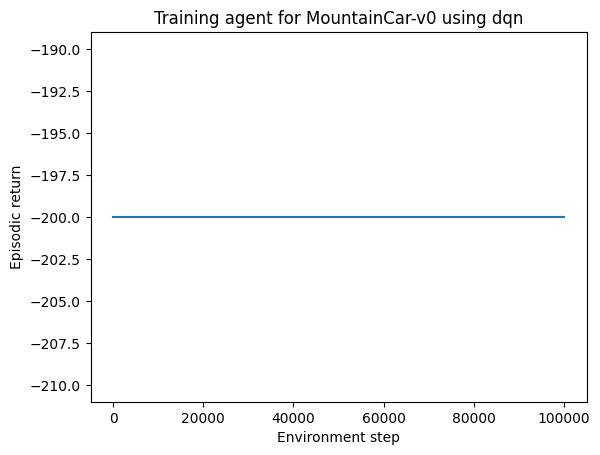

In [18]:
episode_lengths, episode_returns = evaluation
mean_return = episode_returns.mean(axis=1)

plt.plot(jax.numpy.linspace(0, algo.total_timesteps, len(mean_return)), mean_return)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Training agent for {env_str} using {algo_str}")
plt.show()

# Soft Actor-Critic (sac)